<a href="https://colab.research.google.com/github/AjwadTahrir/MachineLearningFinalProject/blob/main/MachineLearningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Load

In [ ]:

# # Regression and Classification on Crop Data
# %%
# --- Initial Setup and Imports ---
from IPython import get_ipython
from IPython.display import display
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression # Import LogisticRegression here too
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree
from sklearn.metrics import (
    mean_absolute_error, r2_score, mean_squared_error,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler # Import StandardScaler for NN
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- Step 0: Load the raw datasets ---
print("--- Loading Raw Data ---")
try:
    df_production = pd.read_csv('crops_district_production.csv')
    df_area = pd.read_csv('crops_district_area.csv')
    print("CSV files loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure 'crops_district_production.csv' and 'crops_district_area.csv' are uploaded to your Colab environment.")
    # Creating empty DataFrames to avoid NameError if files are not found
    df_production = pd.DataFrame()
    df_area = pd.DataFrame()
    exit() # Exit if files are not found




--- Loading Raw Data ---
CSV files loaded successfully.


# Merge Dataset

In [ ]:
# ## Data Loading, Merging, and Preprocessing (Single Pass)
# %%
# --- Step 1: Merge the datasets ---
print("\n--- Merging DataFrames ---")
if not df_production.empty and not df_area.empty:
    common_cols = [
        'date',
        'state',
        'district',
        'crop_type',
        'crop_species'
    ]

    # Clean column names by stripping whitespace
    df_production.columns = df_production.columns.str.strip()
    df_area.columns = df_area.columns.str.strip()

    merged_df = pd.merge(df_production, df_area, on=common_cols, how='inner')

    print("Merged DataFrame Head:")
    print(merged_df.head())

    # Convert 'date' column to datetime objects
    merged_df['date'] = pd.to_datetime(merged_df['date'])
    print(f"\nYears in the merged dataset: {merged_df['date'].dt.year.unique()}")
else:
    print("Cannot proceed with merge, one or both DataFrames are empty due to file not found error.")
    exit() # Exit if merge cannot proceed


# --- Step 2: Data Preprocessing and Cleaning ---
print("\n--- Data Preprocessing ---")

# a. Extract 'year' from 'date' column
merged_df['year'] = merged_df['date'].dt.year

# b. Handle Missing Values
print("\nMissing values in merged DataFrame before final cleaning:")
print(merged_df.isnull().sum())

initial_rows = merged_df.shape[0]
merged_df.dropna(subset=['production', 'planted_area'], inplace=True)
if merged_df.shape[0] < initial_rows:
    print(f"Dropped {initial_rows - merged_df.shape[0]} rows with missing 'production' or 'planted_area'.")
else:
    print("No missing values found in 'production' or 'planted_area'.")

# --- Create the categorical target variable ('is_high_yield') for classification ---
print("\n--- Creating Classification Target Variable ---")
# Calculate the median *after* dropping rows with missing production
median_production = merged_df['production'].median()
print(f"Median production: {median_production:.2f} metric tonnes")

# Create the binary classification target
merged_df['is_high_yield'] = (merged_df['production'] > median_production).astype(int) # Convert boolean to integer (0 or 1)
print("\nDistribution of 'is_high_yield' (0 = Low Yield, 1 = High Yield):")
print(merged_df['is_high_yield'].value_counts())
print(f"({merged_df['is_high_yield'].value_counts(normalize=True)[1]*100:.2f}% High Yield, "
      f"{merged_df['is_high_yield'].value_counts(normalize=True)[0]*100:.2f}% Low Yield)")


# c. Encode Categorical Variables (Features for Models)
categorical_cols = [
    'state',
    'district',
    'crop_type',
    'crop_species'
]

# Apply One-Hot Encoding to features that will be used by models
# We drop the original 'date' column as 'year' is extracted.
# We do NOT drop 'production' or 'is_high_yield' here, as they are our targets.
# We'll separate features (X) and targets (y_reg, y_cls) *after* encoding.
merged_df_encoded = pd.get_dummies(merged_df.drop(columns=['date']), columns=categorical_cols, drop_first=True)

print("\nDataFrame after One-Hot Encoding (Head):")
print(merged_df_encoded.head())

print("\nDataFrame after One-Hot Encoding (Info):")
merged_df_encoded.info()



--- Merging DataFrames ---
Merged DataFrame Head:
         date  state    district   crop_type  crop_species  production  \
0  2017-01-01  Johor  Batu Pahat  cash_crops       cassava       920.5   
1  2017-01-01  Johor  Batu Pahat  cash_crops    groundnuts         0.0   
2  2017-01-01  Johor  Batu Pahat  cash_crops    sweet_corn         0.0   
3  2017-01-01  Johor  Batu Pahat  cash_crops  sweet_potato       350.0   
4  2017-01-01  Johor  Batu Pahat  cash_crops           yam       395.4   

   planted_area  
0          39.0  
1           0.0  
2           0.0  
3          25.0  
4          22.6  

Years in the merged dataset: [2017]

--- Data Preprocessing ---

Missing values in merged DataFrame before final cleaning:
date            0
state           0
district        0
crop_type       0
crop_species    0
production      0
planted_area    0
year            0
dtype: int64
No missing values found in 'production' or 'planted_area'.

--- Creating Classification Target Variable ---
Median 

# Define Features

In [ ]:

# ## Define Features (X) and Targets (y_reg, y_cls)
# %%
# --- Step 3: Define Features and Targets for Both Tasks ---
print("\n--- Defining Features and Targets ---")

# Regression target: 'production'
y_reg = merged_df_encoded['production']

# Classification target: 'is_high_yield'
y_cls = merged_df_encoded['is_high_yield']

# Features (X): all other columns except the targets
# Ensure we drop both target columns from the features DataFrame
X = merged_df_encoded.drop(columns=['production', 'is_high_yield'])

print(f"Shape of X (features): {X.shape}")
print(f"Shape of y_reg (regression target 'production'): {y_reg.shape}")
print(f"Shape of y_cls (classification target 'is_high_yield'): {y_cls.shape}")



--- Defining Features and Targets ---
Shape of X (features): (7255, 260)
Shape of y_reg (regression target 'production'): (7255,)
Shape of y_cls (classification target 'is_high_yield'): (7255,)


# Split Data

In [ ]:
# ## Split Data to Train and Test (Single Split)
# %%
# --- Step 4: Split Data into Training and Testing Sets ---
print("\n--- Splitting Data ---")
# Using 80% for training and 20% for testing
# random_state ensures that your split is reproducible
# stratify=y_cls is used because the classification target is binary and we want
# to ensure the class distribution is similar in train and test sets.
# This split is suitable for both regression and classification tasks as X is shared.
X_train, X_test, y_train_reg, y_test_reg, y_train_cls, y_test_cls = train_test_split(
    X, y_reg, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

print(f"Training set features (X_train) shape: {X_train.shape}")
print(f"Testing set features (X_test) shape: {X_test.shape}")
print(f"Training set regression target (y_train_reg) shape: {y_train_reg.shape}")
print(f"Testing set regression target (y_test_reg) shape: {y_test_reg.shape}")
print(f"Training set classification target (y_train_cls) shape: {y_train_cls.shape}")
print(f"Testing set classification target (y_test_cls) shape: {y_test_cls.shape}")

# --- Feature Scaling (for models that require it, like NN) ---
print("\n--- Scaling Features (for Neural Networks) ---")
scaler = StandardScaler()
# Fit on training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled using StandardScaler.")



--- Splitting Data ---
Training set features (X_train) shape: (5804, 260)
Testing set features (X_test) shape: (1451, 260)
Training set regression target (y_train_reg) shape: (5804,)
Testing set regression target (y_test_reg) shape: (1451,)
Training set classification target (y_train_cls) shape: (5804,)
Testing set classification target (y_test_cls) shape: (1451,)

--- Scaling Features (for Neural Networks) ---
Features scaled using StandardScaler.


# Model

## Regression Model

### Random Forest Regressor

In [ ]:

# ### Train Data using Random Forest Regressor
# %%
# --- Step 5: Model Training (Random Forest Regressor) ---
print("\n--- Model Training (Random Forest Regressor) ---")

# Initialize the RandomForestRegressor
# Use the regression target (y_train_reg)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

print("Training the Random Forest Regressor model...")
rf_model.fit(X_train, y_train_reg) # Use regression target
print("Model training complete!")



--- Model Training (Random Forest Regressor) ---
Training the Random Forest Regressor model...
Model training complete!


#### Evaluate

In [ ]:

# ### Evaluate Random Forest Regressor
# %%
# --- Step 6: Model Evaluation (Random Forest) ---
print("\n--- Random Forest Regressor Model Evaluation ---")

# Make predictions on the test set (using regression features and target)
y_pred_rf = rf_model.predict(X_test) # Use regression features

# Evaluation metrics
mae_rf = mean_absolute_error(y_test_reg, y_pred_rf) # Use regression target
rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_rf)) # Use regression target
r2_rf = r2_score(y_test_reg, y_pred_rf) # Use regression target

print(f"Mean Absolute Error (MAE): {mae_rf:.2f} metric tonnes")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f} metric tonnes")
print(f"R-squared (R²): {r2_rf:.4f}")

# Comparison preview
print("\nSome Actual vs Predicted Production values (Random Forest):")
results_rf = pd.DataFrame({'Actual': y_test_reg, 'Predicted_RF': y_pred_rf}) # Use regression target
print(results_rf.head(10))



--- Random Forest Regressor Model Evaluation ---
Mean Absolute Error (MAE): 224.56 metric tonnes
Root Mean Squared Error (RMSE): 1935.27 metric tonnes
R-squared (R²): 0.5409

Some Actual vs Predicted Production values (Random Forest):
      Actual  Predicted_RF
2219   38.88     19.710865
6632    0.00      0.000000
1059  187.50    256.097628
1853    0.00      0.000000
3202    0.00      0.003900
2082    0.00      0.000000
1832    0.00      0.000000
1751    0.00      0.000000
844     0.00      0.000000
1215    0.00      0.000000


#### Visualise


--- Visualizing Random Forest Model Performance ---


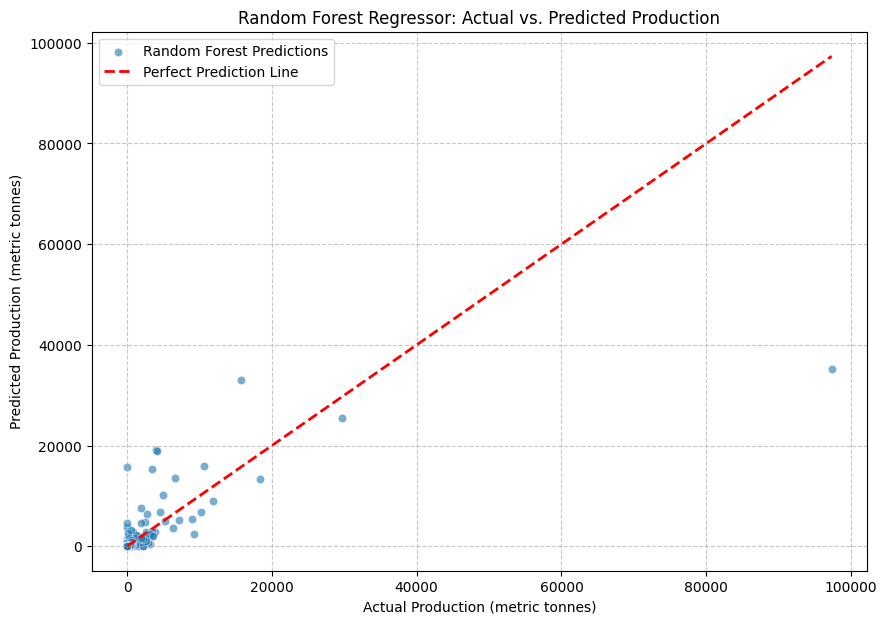

In [ ]:

# ### Visualize Random Forest Regressor
# %%
# --- Step 7: Visualization of Random Forest Regressor Performance ---
print("\n--- Visualizing Random Forest Model Performance ---")

plt.figure(figsize=(10, 7))
# Use regression targets and predictions for the plot
sns.scatterplot(x=y_test_reg, y=y_pred_rf, alpha=0.6, label='Random Forest Predictions')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel("Actual Production (metric tonnes)")
plt.ylabel("Predicted Production (metric tonnes)")
plt.title("Random Forest Regressor: Actual vs. Predicted Production")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


#### Saved Model

In [ ]:

# ### Save Random Forest Regressor Model
# %%
# --- Step 8: Saving the Trained Random Forest Regressor Model ---
print("\n--- Saving Random Forest Regressor Model ---")
output_model_filename_rf = 'Random_Forest_Regressor_crop_model.joblib'
joblib.dump(rf_model, output_model_filename_rf)
print(f"Trained Random Forest Regressor model saved to: {output_model_filename_rf}")



--- Saving Random Forest Regressor Model ---
Trained Random Forest Regressor model saved to: Random_Forest_Regressor_crop_model.joblib


### Linear Regression

In [ ]:
# ### Train Data using Linear Regression
# %%
# --- Step 5: Model Training (Linear Regression) ---
print("\n--- Model Training (Linear Regression) ---")
# Initialize the LinearRegression model
# Use the regression target (y_train_reg)
model_lr = LinearRegression(n_jobs=-1) # Using a different variable name (model_lr) to avoid confusion

print("Training the Linear Regression model...")
model_lr.fit(X_train, y_train_reg) # Use regression target
print("Model training complete!")


--- Model Training (Linear Regression) ---
Training the Linear Regression model...
Model training complete!


#### Evaluate

In [ ]:

# ### Evaluate Linear Regression
# %%
# --- Step 6: Model Evaluation (Linear Regression) ---
print("\n--- Linear Regression Model Evaluation ---")

# Make predictions on the test set (using regression features)
y_pred_lr = model_lr.predict(X_test) # Use regression features

# Calculate Mean Absolute Error
mae_lr = mean_absolute_error(y_test_reg, y_pred_lr) # Use regression target
print(f"Mean Absolute Error (MAE): {mae_lr:.2f} metric tonnes")

# Calculate Root Mean Squared Error
rmse_lr = np.sqrt(mean_squared_error(y_test_reg, y_pred_lr)) # Use regression target
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.2f} metric tonnes")

# Calculate R-squared
r2_lr = r2_score(y_test_reg, y_pred_lr) # Use regression target
print(f"R-squared (R²): {r2_lr:.4f}")

# Optional: Display some actual vs predicted values
print("\nSome Actual vs Predicted Production values (Linear Regression):")
results_lr = pd.DataFrame({'Actual': y_test_reg, 'Predicted_LR': y_pred_lr}) # Use regression target
print(results_lr.head(10))

# For Linear Regression, you can also inspect coefficients
print("\nModel Coefficients (for Linear Regression - top 10 by absolute value):")
# Create a DataFrame to show coefficients for each feature
coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_lr.coef_ # Use model_lr
})
# Sort by absolute value of coefficient to see most impactful features
coefficients_df['Abs_Coefficient'] = np.abs(coefficients_df['Coefficient'])
print(coefficients_df.sort_values(by='Abs_Coefficient', ascending=False).head(10))



--- Linear Regression Model Evaluation ---
Mean Absolute Error (MAE): 462.92 metric tonnes
Root Mean Squared Error (RMSE): 1698.27 metric tonnes
R-squared (R²): 0.6465

Some Actual vs Predicted Production values (Linear Regression):
      Actual  Predicted_LR
2219   38.88     91.343889
6632    0.00   -174.268338
1059  187.50    302.960029
1853    0.00     41.100587
3202    0.00   -168.923597
2082    0.00    -62.497103
1832    0.00     65.728417
1751    0.00    178.395310
844     0.00   -336.480466
1215    0.00     42.973157

Model Coefficients (for Linear Regression - top 10 by absolute value):
                    Feature  Coefficient  Abs_Coefficient
60          district_Kluang  2872.434398      2872.434398
233  crop_species_pineapple  1745.979119      1745.979119
198     crop_species_durian -1489.780007      1489.780007
258    crop_species_yambean  1217.632534      1217.632534
58           district_Kinta   991.352454       991.352454
103          district_Mukah  -987.467007       98

#### Visualise


--- Visualizing Linear Regression Model Performance ---


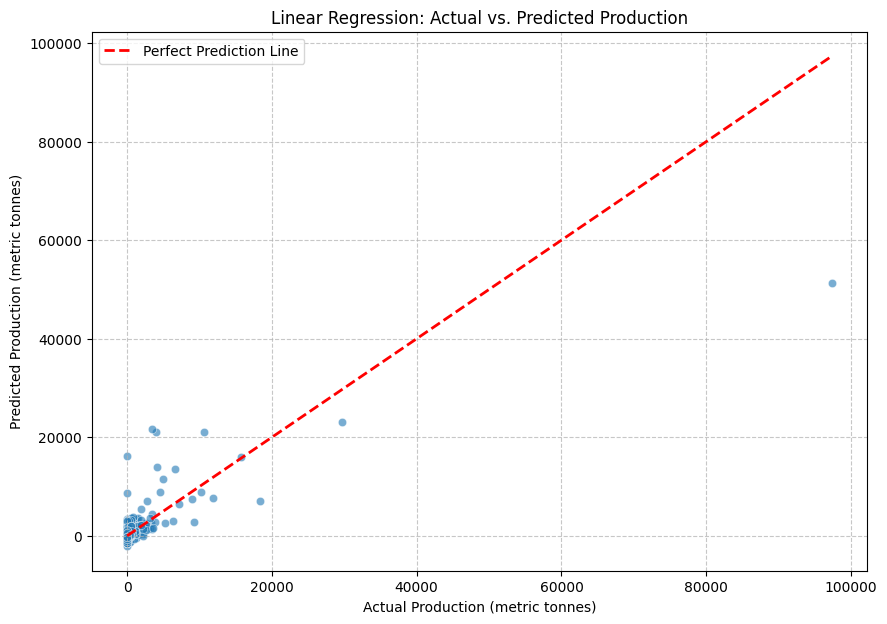

In [ ]:

# ### Visualize Linear Regression
# %%
# --- Step 7: Visualization of Linear Regression Performance ---
print("\n--- Visualizing Linear Regression Model Performance ---")

plt.figure(figsize=(10, 7))
# Use regression targets and predictions for the plot
sns.scatterplot(x=y_test_reg, y=y_pred_lr, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel("Actual Production (metric tonnes)")
plt.ylabel("Predicted Production (metric tonnes)")
plt.title("Linear Regression: Actual vs. Predicted Production")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


#### Saved Model

In [ ]:

# ### Save Linear Regression Model
# %%
# --- Step 8: Saving the Trained Linear Regression Model ---
print("\n--- Saving Linear Regression Model ---")
output_model_filename_lr = 'linear_regression_crop_model.joblib'
joblib.dump(model_lr, output_model_filename_lr) # Use model_lr
print(f"Trained Linear Regression model saved to: {output_model_filename_lr}")



--- Saving Linear Regression Model ---
Trained Linear Regression model saved to: linear_regression_crop_model.joblib


## Classification Model

### Logistic Regression

In [ ]:

# ### Train Data using Logistic Regression
# %%
# --- Step 5: Model Training (Logistic Regression) ---
print("\n--- Model Training (Logistic Regression) ---")
# Initialize the LogisticRegression model
# Use the classification target (y_train_cls)
model_logreg = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', n_jobs=-1) # Using a different variable name

print("Training the Logistic Regression model...")
model_logreg.fit(X_train, y_train_cls) # Use classification target
print("Model training complete!")



--- Model Training (Logistic Regression) ---
Training the Logistic Regression model...
Model training complete!


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


#### Evaluate and Visualise


--- Logistic Regression Model Evaluation ---

Classification Report:
              precision    recall  f1-score   support

   Low Yield       0.80      0.82      0.81       761
  High Yield       0.80      0.77      0.78       690

    accuracy                           0.80      1451
   macro avg       0.80      0.80      0.80      1451
weighted avg       0.80      0.80      0.80      1451


Confusion Matrix:


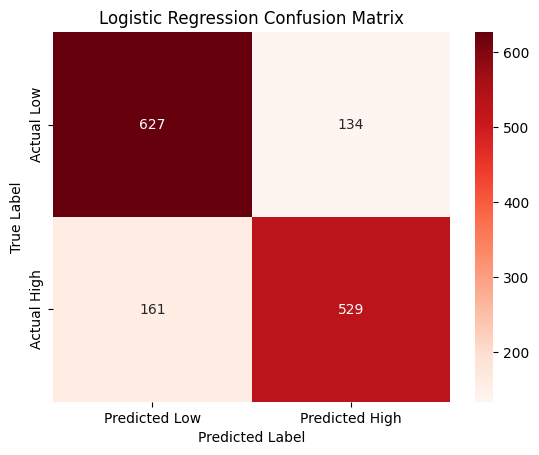

In [ ]:

# ### Evaluate Logistic Regression Model
# %%
# --- Step 6: Model Evaluation (Logistic Regression) ---
print("\n--- Logistic Regression Model Evaluation ---")

# Make predictions on the unseen test set (using classification features and target)
y_pred_logreg = model_logreg.predict(X_test) # Use classification features

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_cls, y_pred_logreg, target_names=['Low Yield', 'High Yield'])) # Use classification target

# Generate and display the Confusion Matrix
print("\nConfusion Matrix:")
cm_logreg = confusion_matrix(y_test_cls, y_pred_logreg) # Use classification target
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Predicted Low', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual High'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#### Save Model

In [ ]:
# ### Save Logistic Regression Model
# %%
# --- Step 8: Saving the Trained Logistic Regression Model ---
print("\n--- Saving Logistic Regression Model ---")
output_model_filename_logreg = 'logistic_regression_crop_classifier_model.joblib'
joblib.dump(model_logreg, output_model_filename_logreg) # Use model_logreg
print(f"Trained Logistic Regression model saved to: {output_model_filename_logreg}")


--- Saving Logistic Regression Model ---
Trained Logistic Regression model saved to: logistic_regression_crop_classifier_model.joblib


### Decision Tree

In [ ]:

# ### Train Data using Decision Tree Classifier
# %%
# --- Step 5: Model Training (Decision Tree Classifier) ---
print("\n--- Training Decision Tree Classifier ---")

# Initialize the Decision Tree Classifier
# Use the classification target (y_train_cls)
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
dt_model.fit(X_train, y_train_cls) # Use classification target

print("Decision Tree training complete!")



--- Training Decision Tree Classifier ---
Decision Tree training complete!


#### Evaluate and Visualise


--- Evaluating Decision Tree Classifier ---
Accuracy: 0.9235
Precision: 0.9038
Recall: 0.9391
F1 Score: 0.9211

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       761
           1       0.90      0.94      0.92       690

    accuracy                           0.92      1451
   macro avg       0.92      0.92      0.92      1451
weighted avg       0.92      0.92      0.92      1451

Confusion Matrix:
[[692  69]
 [ 42 648]]


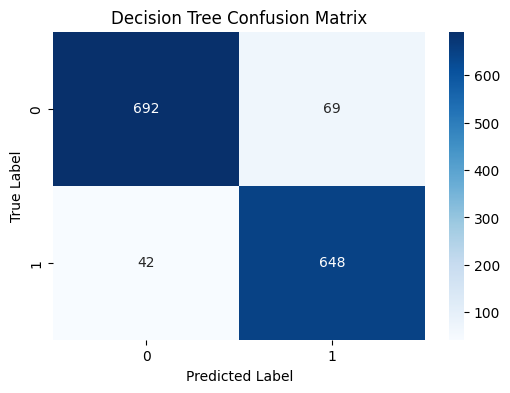

In [ ]:

# ### Evaluate and Visualize Decision Tree Classifier
# %%
print("\n--- Evaluating Decision Tree Classifier ---")

# Predict on the test set (using classification features)
y_pred_dt = dt_model.predict(X_test) # Use classification features

# Calculate and print metrics
accuracy_dt = accuracy_score(y_test_cls, y_pred_dt) # Use classification target
precision_dt = precision_score(y_test_cls, y_pred_dt) # Use classification target
recall_dt = recall_score(y_test_cls, y_pred_dt) # Use classification target
f1_dt = f1_score(y_test_cls, y_pred_dt) # Use classification target

print(f"Accuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1 Score: {f1_dt:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_cls, y_pred_dt)) # Use classification target

print("Confusion Matrix:")
cm_dt = confusion_matrix(y_test_cls, y_pred_dt) # Use classification target
print(cm_dt)

# Optional: Visualize confusion matrix with seaborn heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Decision Tree Confusion Matrix')
plt.show()


#### Save Model

In [ ]:

# ### Save Decision Tree Classifier Model
# %%
# --- Step 8: Saving the Trained Decision Tree Classifier Model ---
print("\n--- Saving Decision Tree Classifier Model ---")
output_model_filename_dt = 'Decision_Tree_crop_classifier_model.joblib'
joblib.dump(dt_model, output_model_filename_dt)
print(f"Trained Decision Tree classifier model saved to: {output_model_filename_dt}")



--- Saving Decision Tree Classifier Model ---
Trained Decision Tree classifier model saved to: Decision_Tree_crop_classifier_model.joblib


## Neural Network

In [ ]:

# ## Neural Network (Multi-Task)
# %%
# ==============================================================================
#                 BUILDING THE MULTI-TASK NEURAL NETWORK (TensorFlow)
# ==============================================================================
print("\n" + "="*70)
print("  BUILDING MULTI-TASK NEURAL NETWORK (TensorFlow/Keras)")
print("="*70)

# Define the input layer
# Use the shape of the scaled training features
input_layer = keras.Input(shape=(X_train_scaled.shape[1],), name='input_features')

# Shared hidden layers
shared_dense_1 = layers.Dense(128, activation='relu', name='shared_dense_1')(input_layer)
shared_dropout_1 = layers.Dropout(0.2)(shared_dense_1)
shared_dense_2 = layers.Dense(64, activation='relu', name='shared_dense_2')(shared_dropout_1)
shared_dropout_2 = layers.Dropout(0.2)(shared_dense_2)

# Regression Head
regression_output = layers.Dense(1, activation='linear', name='regression_output')(shared_dropout_2)

# Classification Head
# Ensure the output layer for binary classification uses sigmoid activation
classification_output = layers.Dense(1, activation='sigmoid', name='classification_output')(shared_dropout_2)

# Create the Keras Model with multiple outputs
multi_task_model = keras.Model(
    inputs=input_layer,
    outputs=[regression_output, classification_output],
    name='crop_multi_task_nn'
)

# Compile the model
multi_task_model.compile(
    optimizer='adam',
    loss={
        'regression_output': 'mse',
        'classification_output': 'binary_crossentropy'
    },
    metrics={
        'regression_output': ['mae', 'mse'],
        'classification_output': ['accuracy']
    }
)

multi_task_model.summary()





  BUILDING MULTI-TASK NEURAL NETWORK (TensorFlow/Keras)


Model: "crop_multi_task_nn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 260)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense_1      │ (None, 128)       │     33,408 │ input_features[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ shared_dense_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense_2      │ (None, 64)        │      8,256 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ shared_dense_2[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output   │ (None, 1)         │         65 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 1)         │         65 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 41,794 (163.26 KB)

 Trainable params: 41,794 (163.26 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [ ]:
# ### Train Neural Network
# %%
# --- Step 5: Model Training (Multi-Task Neural Network) ---
print("\n--- Model Training (Multi-Task Neural Network) ---")

# Train the model using scaled features and BOTH targets
history = multi_task_model.fit(
    X_train_scaled,
    {'regression_output': y_train_reg, 'classification_output': y_train_cls},
    epochs=100,
    batch_size=32,
    validation_split=0.2, # Use 20% of training data for validation
    verbose=1
)
print("Multi-Task Neural Network training complete!")



--- Model Training (Multi-Task Neural Network) ---
Epoch 1/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - classification_output_accuracy: 0.4823 - classification_output_loss: 0.8858 - loss: 20661788.0000 - regression_output_loss: 20660772.0000 - regression_output_mae: 394.2481 - regression_output_mse: 20661788.0000 - val_classification_output_accuracy: 0.5082 - val_classification_output_loss: 0.7249 - val_loss: 26659086.0000 - val_regression_output_loss: 26146186.0000 - val_regression_output_mae: 427.5276 - val_regression_output_mse: 26659086.0000
Epoch 2/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - classification_output_accuracy: 0.5000 - classification_output_loss: 1.3736 - loss: 7073131.0000 - regression_output_loss: 7072128.5000 - regression_output_mae: 296.3723 - regression_output_mse: 7073130.5000 - val_classification_output_accuracy: 0.5280 - val_classification_output_loss: 1.1019 - val_loss: 26262116.0000 - val_regression_output_loss: 25754402.0000 - val_regression_output_ma

### Evaluate and Visualise


--- Multi-Task Neural Network Model Evaluation ---

Regression Task Test Results:
  Test Loss (MSE): 2995892.7500
  Test MAE: 0.54 metric tonnes
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
  Test R-squared (R²): 0.6284

Classification Task Test Results:
  Test Loss (Binary Cross-Entropy): 0.7241
  Test Accuracy: 3031434.2500
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

   Low Yield       0.56      0.53      0.54       761
  High Yield       0.51      0.55      0.53       690

    accuracy                           0.54      1451
   macro avg       0.54      0.54      0.54      1451
weighted avg       0.54      0.54      0.54      1451


Confusion Matrix:


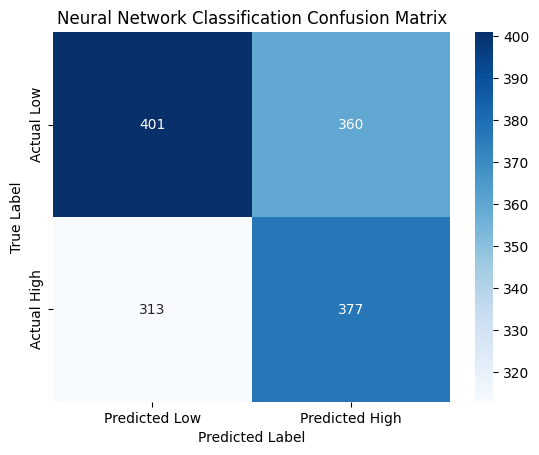


--- Visualizing Neural Network Regression Performance ---


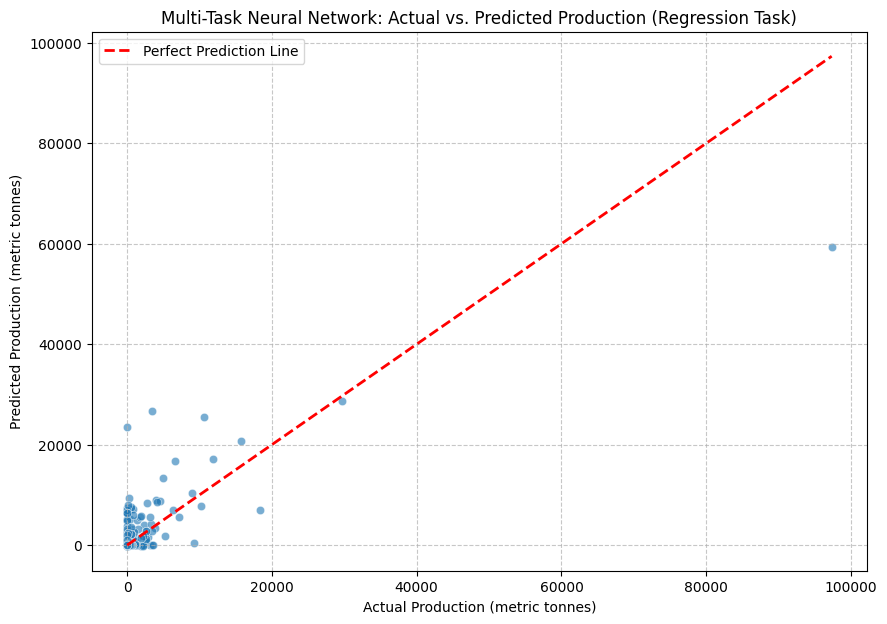

In [ ]:
# ### Evaluate Neural Network
# %%
# --- Step 6: Model Evaluation (Multi-Task Neural Network) ---
print("\n--- Multi-Task Neural Network Model Evaluation ---")

# Evaluate the model on the scaled test set using BOTH targets
test_results = multi_task_model.evaluate(
    X_test_scaled,
    {'regression_output': y_test_reg, 'classification_output': y_test_cls},
    verbose=0
)

# Access metrics by their expected position based on the compile method
reg_loss_val = test_results[1] # regression_output_loss
mae_val = test_results[3]     # regression_output_mae

cls_loss_val = test_results[2] # classification_output_loss
acc_val = test_results[5]     # classification_output_accuracy


# Print evaluation results for regression
print(f"\nRegression Task Test Results:")
print(f"  Test Loss (MSE): {reg_loss_val:.4f}")
print(f"  Test MAE: {mae_val:.2f} metric tonnes")

# Calculate R2 for regression manually from predictions
# Predict returns a list of arrays, one for each output. [0] is the regression output.
y_pred_reg_test = multi_task_model.predict(X_test_scaled)[0]
r2_reg_test = r2_score(y_test_reg, y_pred_reg_test)
print(f"  Test R-squared (R²): {r2_reg_test:.4f}")

# Print evaluation results for classification
print(f"\nClassification Task Test Results:")
print(f"  Test Loss (Binary Cross-Entropy): {cls_loss_val:.4f}")
print(f"  Test Accuracy: {acc_val:.4f}")

# Get classification predictions for detailed report and confusion matrix
# Predict returns a list of arrays. [1] is the classification output (probabilities).
y_pred_cls_proba = multi_task_model.predict(X_test_scaled)[1]
y_pred_cls = (y_pred_cls_proba > 0.5).astype(int) # Convert probabilities to binary predictions (0 or 1)

print("\nClassification Report:")
print(classification_report(y_test_cls, y_pred_cls, target_names=['Low Yield', 'High Yield']))

print("\nConfusion Matrix:")
cm_cls = confusion_matrix(y_test_cls, y_pred_cls)
sns.heatmap(cm_cls, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Low', 'Predicted High'],
            yticklabels=['Actual Low', 'Actual High'])
plt.title('Neural Network Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# --- Visualization of Regression Model Performance ---
print("\n--- Visualizing Neural Network Regression Performance ---")

plt.figure(figsize=(10, 7))
# Use regression targets and predictions for the plot. Flatten prediction array.
sns.scatterplot(x=y_test_reg, y=y_pred_reg_test.flatten(), alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel("Actual Production (metric tonnes)")
plt.ylabel("Predicted Production (metric tonnes)")
plt.title("Multi-Task Neural Network: Actual vs. Predicted Production (Regression Task)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()



### Save model

In [ ]:

# ### Save Preprocessed Data and Neural Network Model
# %%
# --- Step 8: Saving the Preprocessed Data and Trained Neural Network Model ---
print("\n--- Saving Preprocessed Data and Neural Network Model ---")

# Save the preprocessed DataFrame ONCE after all preprocessing is done.
# This file contains both 'production' and 'is_high_yield' targets along with encoded features.
output_csv_filename_preprocessed = 'merged_crop_data_preprocessed_final.csv'
merged_df_encoded.to_csv(output_csv_filename_preprocessed, index=False)
print(f"Final preprocessed data saved to: {output_csv_filename_preprocessed}")


# Save the TensorFlow Keras model
output_model_filename_tf = 'crop_multi_task_nn_model.h5'
multi_task_model.save(output_model_filename_tf)
print(f"Trained Multi-Task Neural Network model saved to: {output_model_filename_tf}")

print("\nProcess complete. You can now download files from your Colab files sidebar.")